#Libraries

In [ ]:
#!pip install catboost

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, RepeatedKFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_log_error, mean_squared_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Random Seed
np.random.seed(0)

# Customize Seaborn
rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

# First Look

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Data Science/Projects/handson-ml2/Housing/input/housing.csv')

In [4]:
data.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


`total_bedrooms` with null values

In [6]:
data.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

possible outliers to check

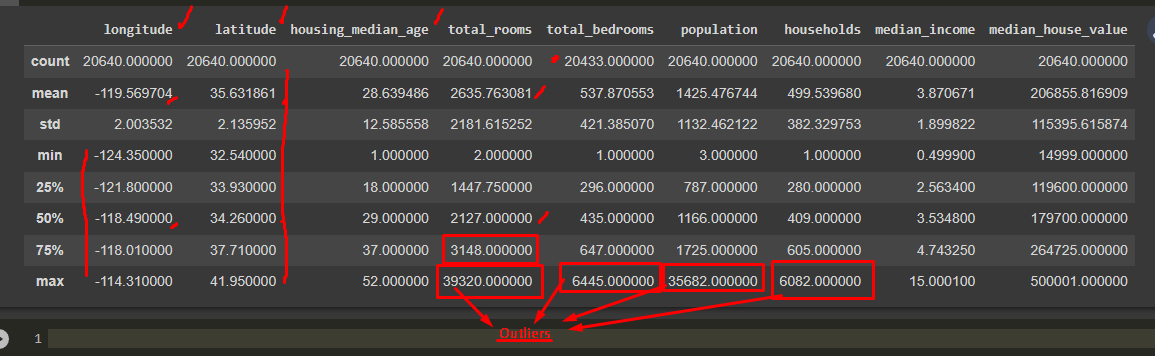

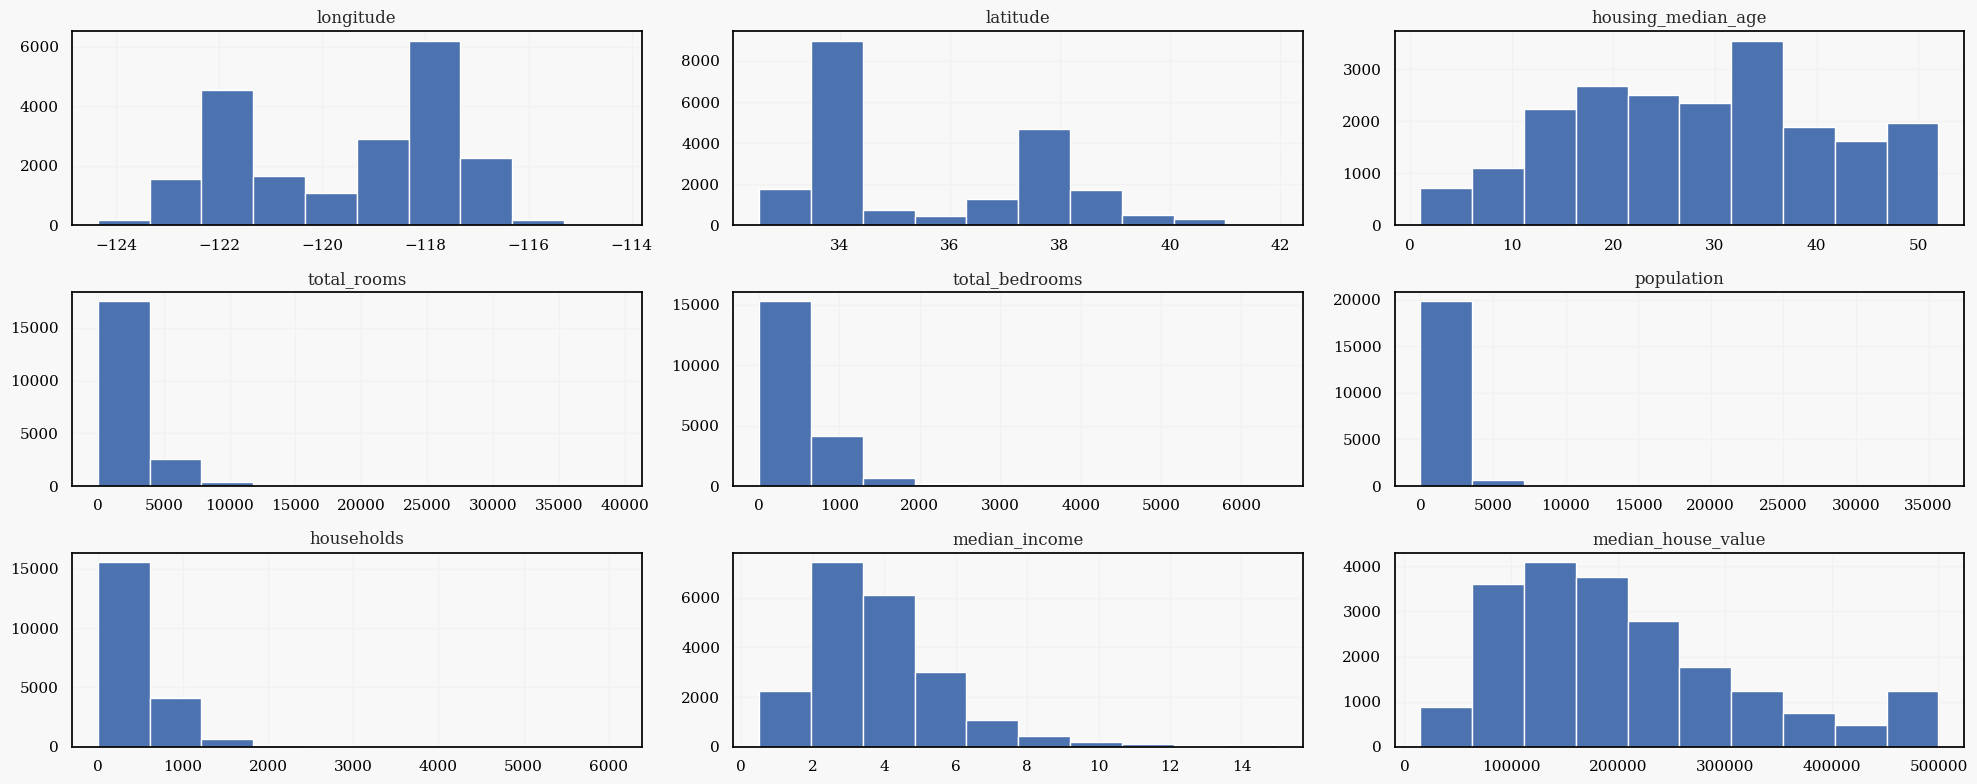

In [7]:
data.hist(figsize=(20,8))
plt.tight_layout()

In [8]:
cols = data.select_dtypes(exclude='object').columns

In [9]:
data.select_dtypes(exclude='object')

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  median_house_value  
0           322.0       126.0         8.3252            452600.0  
1          2401.0      1138.0         8.3014            358500.0  
2           496.0       177.0         7.2574            352100.0  
3           558.0       219.0         5.6431            341300.0  
4           565.0       259.0         3.8462            342200.0  
...           ...         ...            ...                 ...  
20635       845.0       330.0         1.5603             78100.0  
20636       356.0       114.0         2.5568             77100.0  
20637      1007.0       433.0         1.7000             92300.0  
20638       741.0       349.0         1.8672             84700.0  
20639      1387.0       530.0         2.3886             89400.0  

[20640 rows x 9 columns]

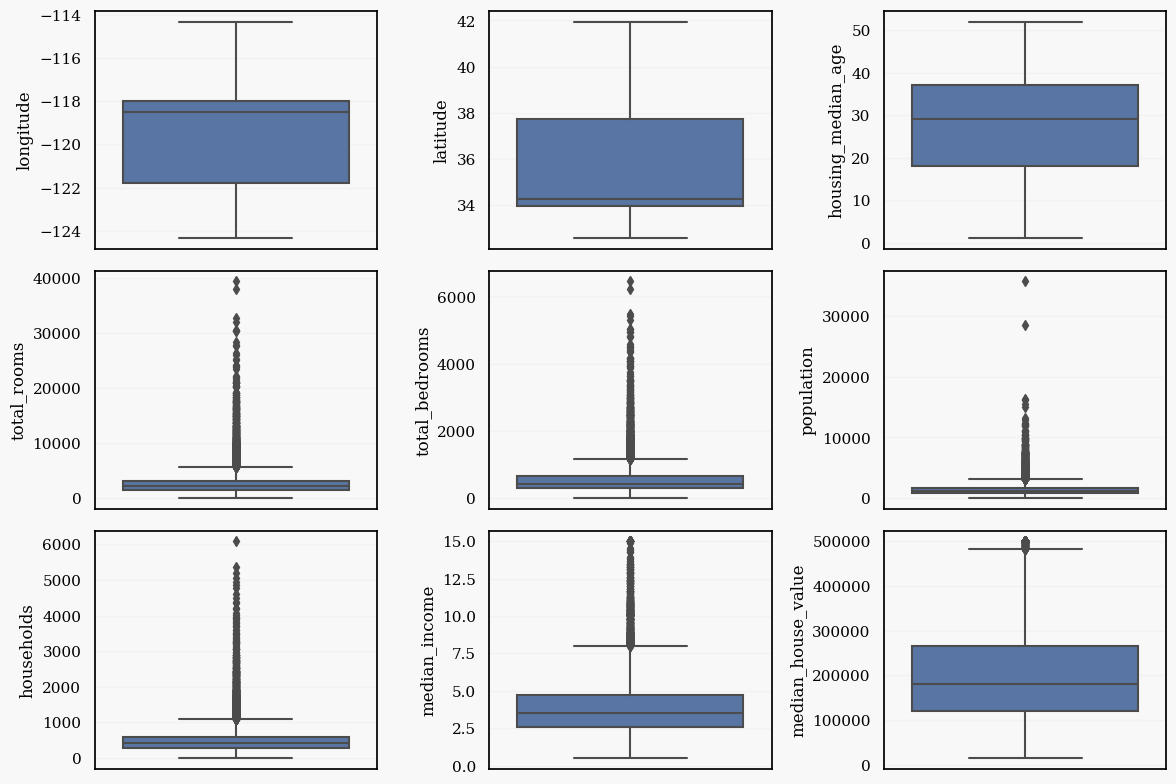

In [10]:
cols = data.select_dtypes(exclude='object').columns

fig, axs = plt.subplots(3,3, figsize=(12,8))
axs = axs.ravel()
for i, col in enumerate(cols):
  sns.boxplot(data, y=col, ax=axs[i])

plt.tight_layout()

<Axes: xlabel='count', ylabel='ocean_proximity'>

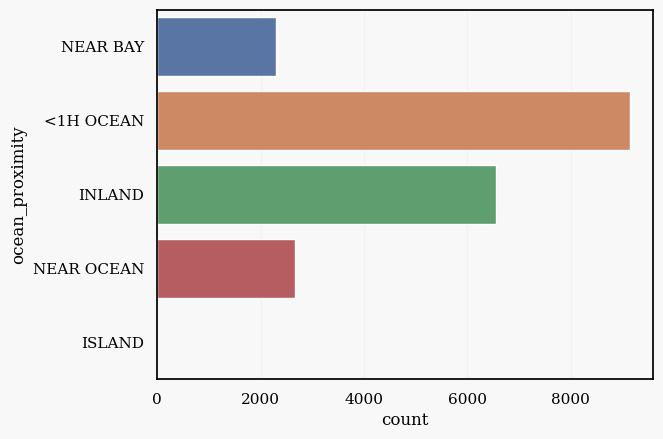

In [11]:
sns.countplot(data, y='ocean_proximity')

# Separe in housing and test
Stratified by income

In [12]:
round(data.median_income,0).value_counts(normalize=True).sort_index()

0.0     0.000581
1.0     0.038905
2.0     0.193314
3.0     0.256202
4.0     0.220252
5.0     0.134835
6.0     0.075824
7.0     0.034060
8.0     0.021463
9.0     0.007510
10.0    0.006492
11.0    0.004167
12.0    0.001841
13.0    0.001502
14.0    0.000484
15.0    0.002568
Name: median_income, dtype: float64

<Axes: >

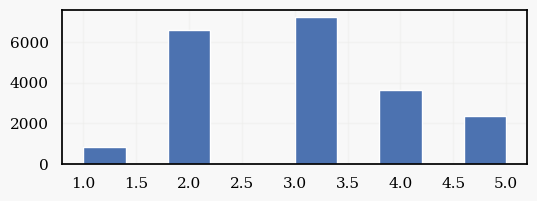

In [13]:
bins = [0, 1.5, 3, 4.5, 6, np.inf]
labels = [1, 2, 3, 4, 5]

data['income_cat'] = pd.cut(data['median_income'], bins=bins, labels=labels)
data['income_cat'].hist(figsize=(6,2))

In [14]:
train, test = train_test_split(data, test_size=0.2, stratify=data['income_cat'])

In [15]:
housing = train.copy()

In [16]:
stratify_view = pd.concat([data['income_cat'].value_counts(normalize=True), 
           housing['income_cat'].value_counts(normalize=True), 
           test['income_cat'].value_counts(normalize=True)], 
          axis=1)

stratify_view.columns = ['data', 'housing', 'test']
stratify_view

data   housing      test
3  0.350581  0.350594  0.350533
2  0.318847  0.318859  0.318798
4  0.176308  0.176296  0.176357
5  0.114438  0.114462  0.114341
1  0.039826  0.039789  0.039971

In [17]:
housing.drop('income_cat', axis=1, inplace=True)

# Analytics

In [18]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

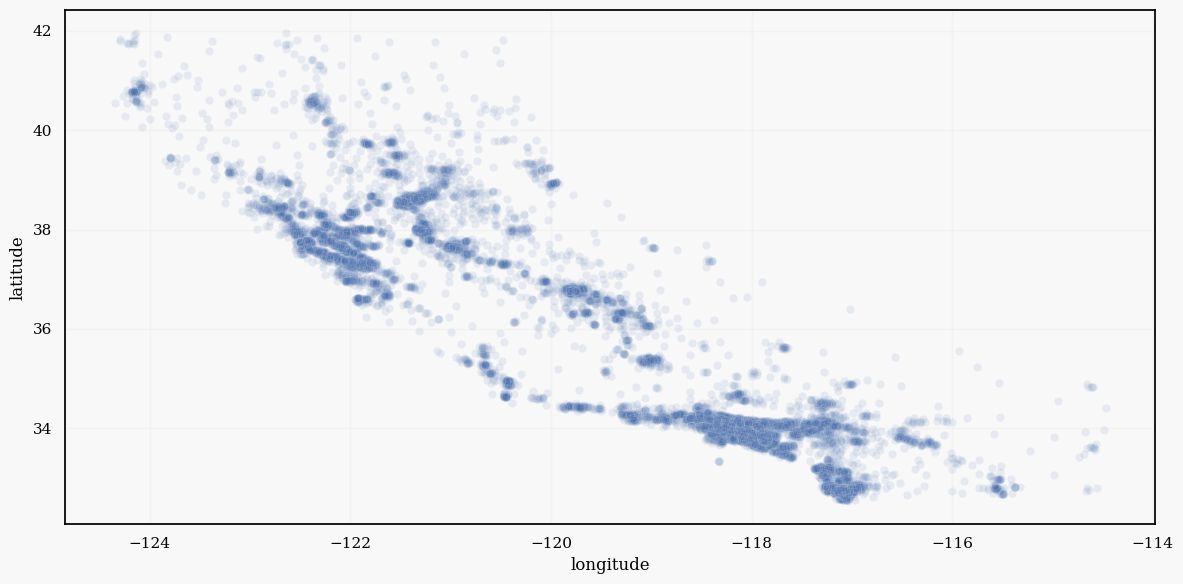

In [19]:
plt.figure(figsize=(12,6))

sns.scatterplot(data=housing, 
                x='longitude', 
                y='latitude', 
                alpha=0.1)

plt.tight_layout()

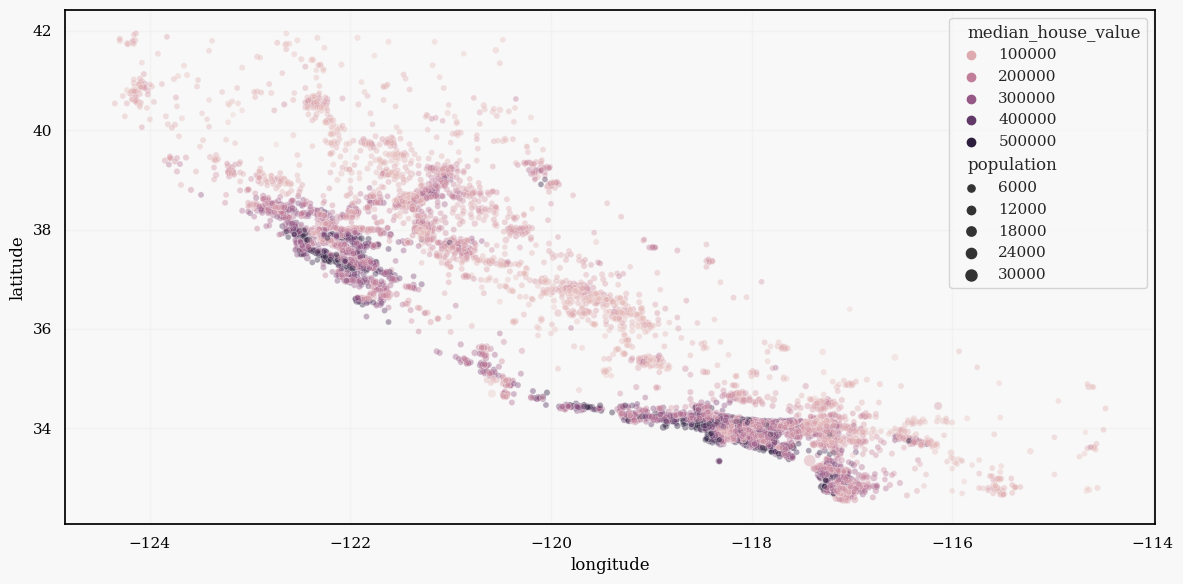

In [20]:
plt.figure(figsize=(12,6))

sns.scatterplot(data=housing, 
                x='longitude', 
                y='latitude', 
                size='population', 
                alpha=0.4, 
                hue='median_house_value')

plt.tight_layout()

In [21]:
corr_matrix = housing.corr(numeric_only = True)

corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688988
total_rooms           0.137430
housing_median_age    0.107227
households            0.069089
total_bedrooms        0.053455
population           -0.023882
longitude            -0.042943
latitude             -0.145757
Name: median_house_value, dtype: float64

In [22]:
potential_vars = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms']

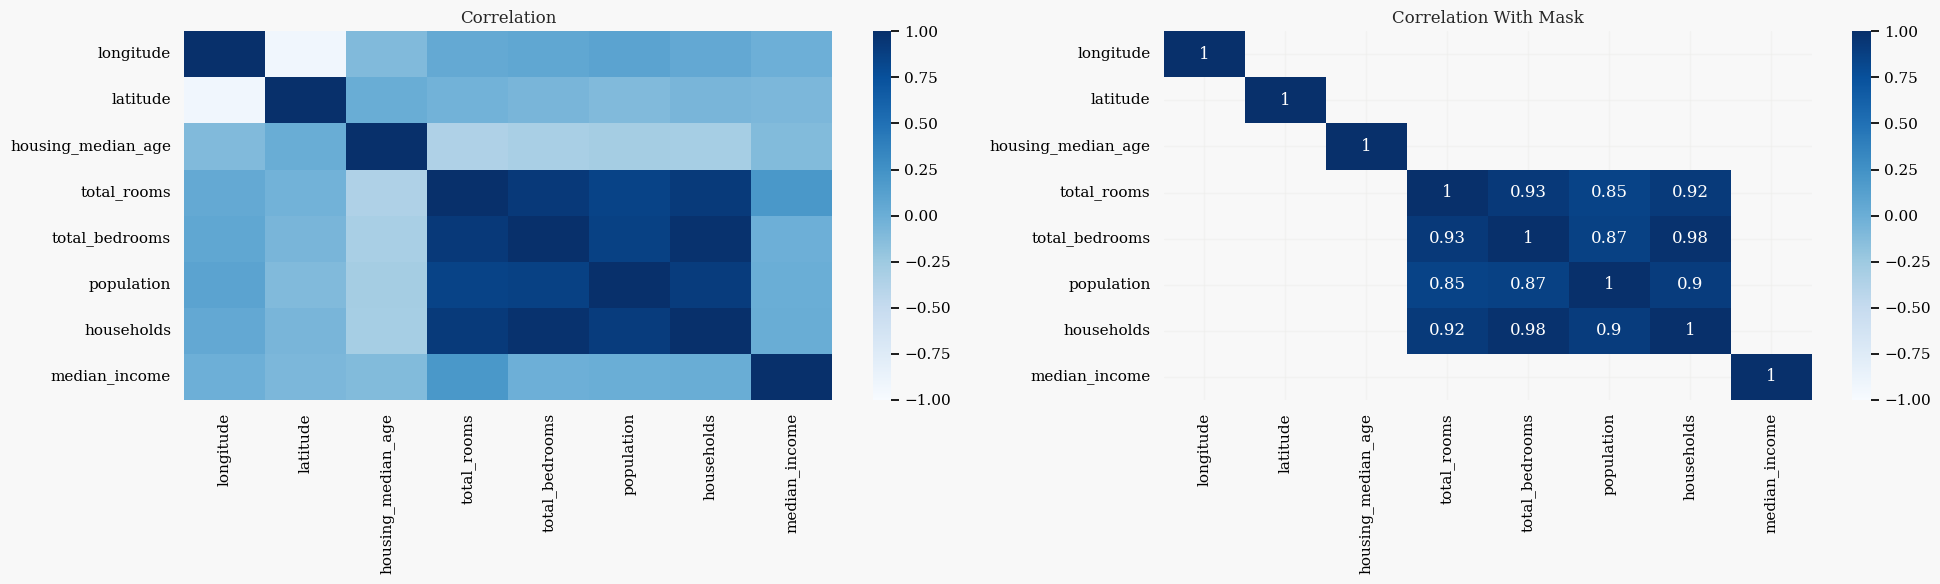

In [23]:
fig, axs = plt.subplots(ncols=2, figsize=(20,6))

corr_matrix = housing.drop('median_house_value', axis=1).corr(numeric_only = True)

axs[0].set_title('Correlation')
sns.heatmap(corr_matrix, 
            cmap='Blues', 
            vmin=-1, 
            ax=axs[0])

axs[1].set_title('Correlation With Mask')
sns.heatmap(corr_matrix, 
            cmap='Blues', 
            vmin=-1, 
            annot=True, 
            mask= corr_matrix < 0.8, 
            ax=axs[1])

plt.tight_layout()

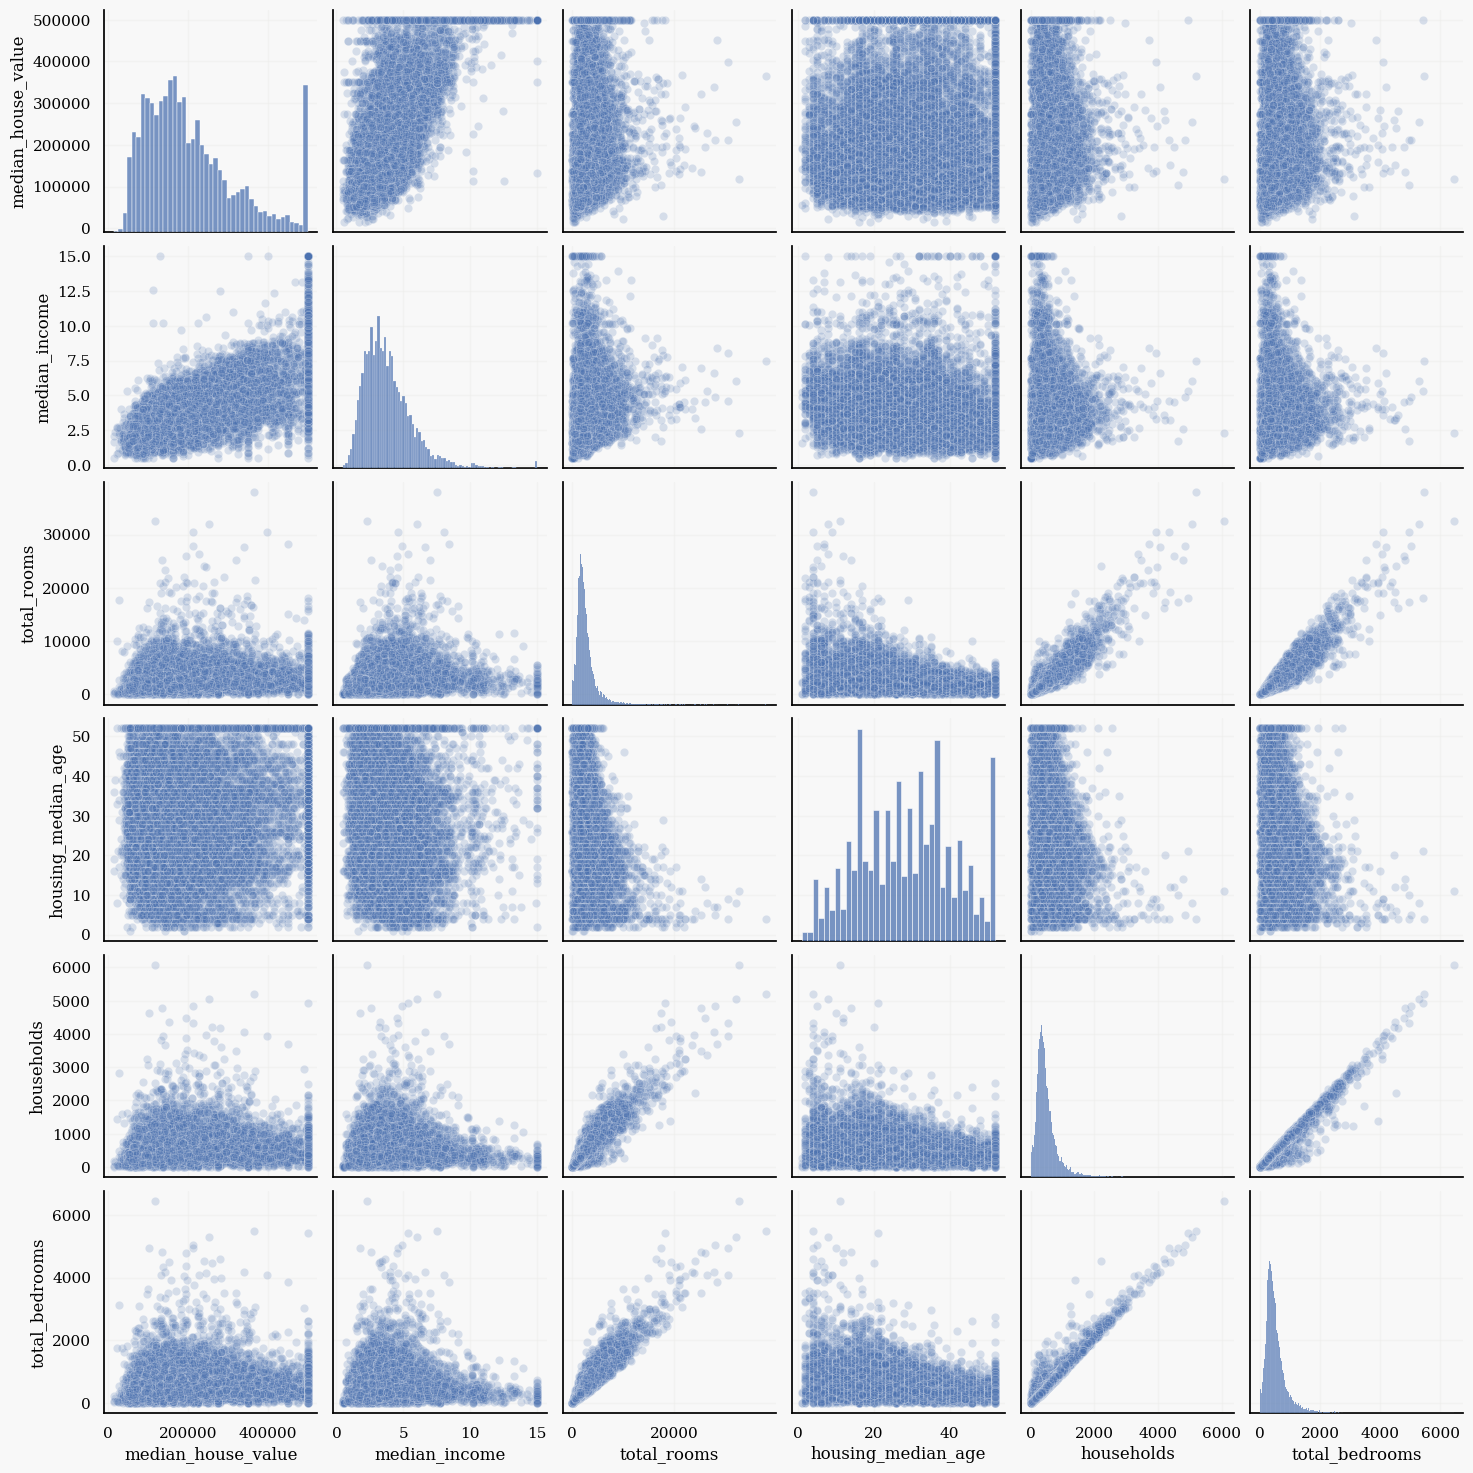

In [24]:
sns.pairplot(housing, x_vars=potential_vars, y_vars=potential_vars,  plot_kws={'alpha':0.2})

<Axes: xlabel='median_house_value', ylabel='ocean_proximity'>

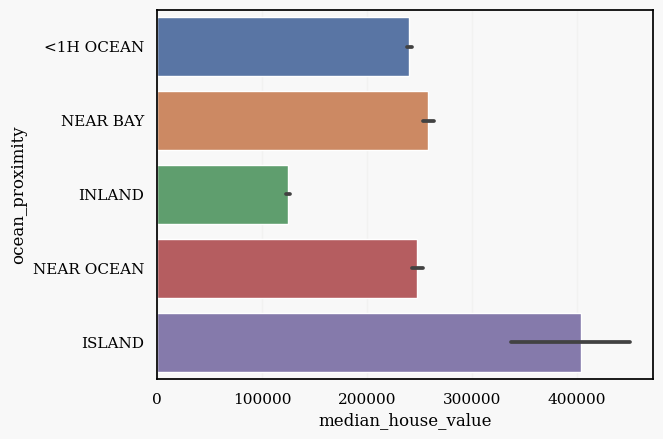

In [25]:
sns.barplot(train, y='ocean_proximity', x='median_house_value')

In [26]:
train.groupby('ocean_proximity')['median_house_value'].describe().transpose()

ocean_proximity      <1H OCEAN         INLAND         ISLAND       NEAR BAY  \
count              7325.000000    5218.000000       4.000000    1816.000000   
mean             240081.395631  124759.547719  403675.000000  258272.220815   
std              106296.794450   70475.193658   71091.648595  122570.778066   
min               17500.000000   14999.000000  300000.000000   22500.000000   
25%              163900.000000   77600.000000  386025.000000  162500.000000   
50%              214200.000000  108250.000000  432350.000000  232000.000000   
75%              289600.000000  148700.000000  450000.000000  342250.000000   
max              500001.000000  500001.000000  450000.000000  500001.000000   

ocean_proximity     NEAR OCEAN  
count              2149.000000  
mean             247971.600745  
std              122752.606398  
min               28300.000000  
25%              148600.000000  
50%              226500.000000  
75%              321200.000000  
max              500001.000000

In [27]:
train[ train['ocean_proximity'] == 'ISLAND']

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
8314    -118.32     33.35                27.0       1675.0           521.0   
8315    -118.33     33.34                52.0       2359.0           591.0   
8317    -118.32     33.34                52.0        996.0           264.0   
8316    -118.32     33.33                52.0       2127.0           512.0   

      population  households  median_income  median_house_value  \
8314       744.0       331.0         2.1579            450000.0   
8315      1100.0       431.0         2.8333            414700.0   
8317       341.0       160.0         2.7361            450000.0   
8316       733.0       288.0         3.3906            300000.0   

     ocean_proximity income_cat  
8314          ISLAND          2  
8315          ISLAND          2  
8317          ISLAND          2  
8316          ISLAND          3

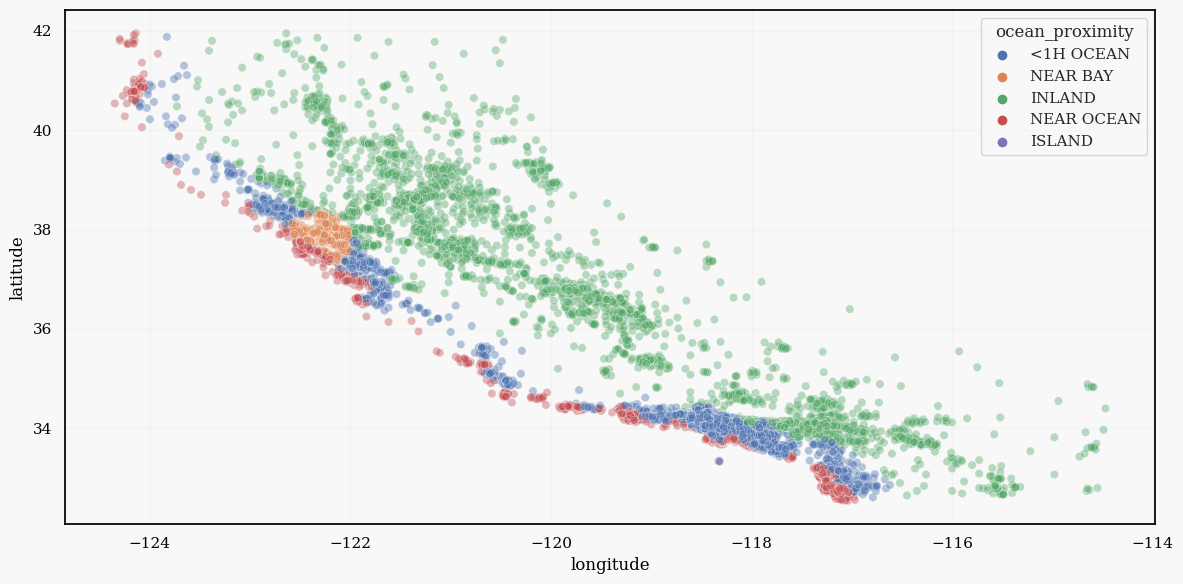

In [28]:
plt.figure(figsize=(12,6))

sns.scatterplot(data=housing, 
                x='longitude', 
                y='latitude', 
                hue='ocean_proximity', 
                alpha=0.4, )

plt.tight_layout()

In [29]:
housing['ocean_proximity'] = housing['ocean_proximity'].apply(lambda x: 'NEAR OCEAN' if x == 'ISLAND' else x)

In [30]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     7325
INLAND        5218
NEAR OCEAN    2153
NEAR BAY      1816
Name: ocean_proximity, dtype: int64

In [31]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

Clean Data

In [32]:
housing['total_bedrooms'].describe()

count    16344.000000
mean       537.120717
std        418.993692
min          1.000000
25%        297.000000
50%        436.000000
75%        646.000000
max       6445.000000
Name: total_bedrooms, dtype: float64

In [33]:
median = housing['total_bedrooms']
housing['total_bedrooms'].fillna(median, inplace=True)

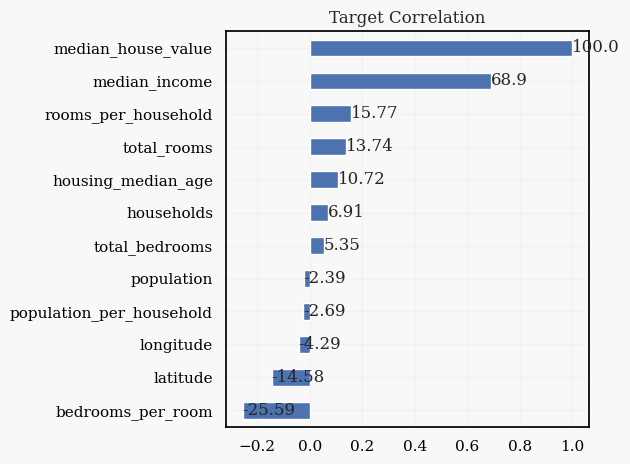

In [34]:
target_corr = housing.corr(numeric_only=True)['median_house_value'].sort_values()

ax = target_corr.plot(kind='barh', title='Target Correlation')

# Adiciona o valor de cada coluna acima dela
for i, v in enumerate(target_corr.values):
    ax.text(v, i, str(round(v*100,2)), ha='left', va='center')

plt.tight_layout()

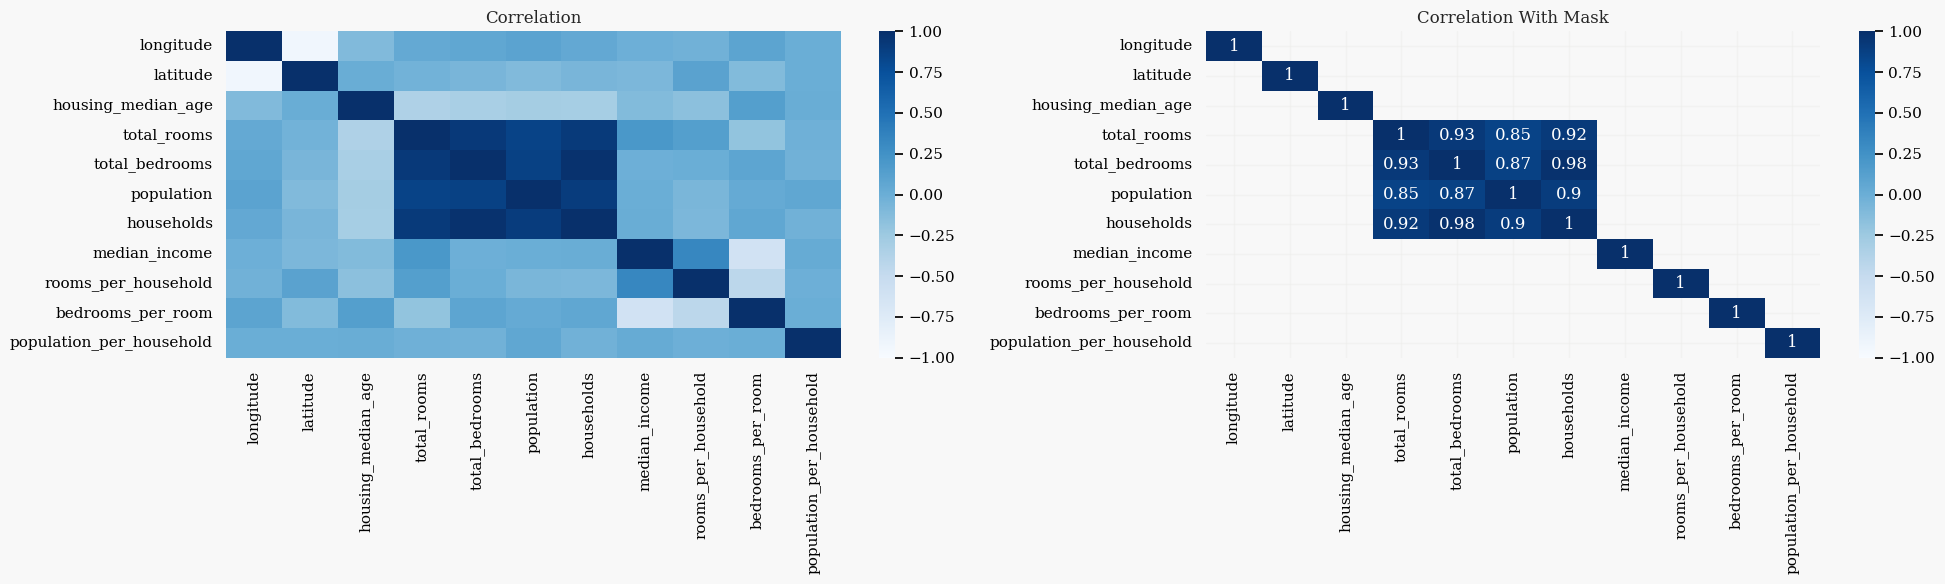

In [35]:
fig, axs = plt.subplots(ncols=2, figsize=(20,6))

corr_matrix = housing.drop('median_house_value', axis=1).corr(numeric_only = True)

axs[0].set_title('Correlation')
sns.heatmap(corr_matrix, 
            cmap='Blues', 
            vmin=-1, 
            ax=axs[0])

axs[1].set_title('Correlation With Mask')
sns.heatmap(corr_matrix, 
            cmap='Blues', 
            vmin=-1, 
            annot=True, 
            mask= corr_matrix < 0.5, 
            ax=axs[1])

plt.tight_layout()

In [36]:
high_corr = [ 'total_bedrooms', 'population', 'households']
housing = housing.drop(high_corr, axis=1)

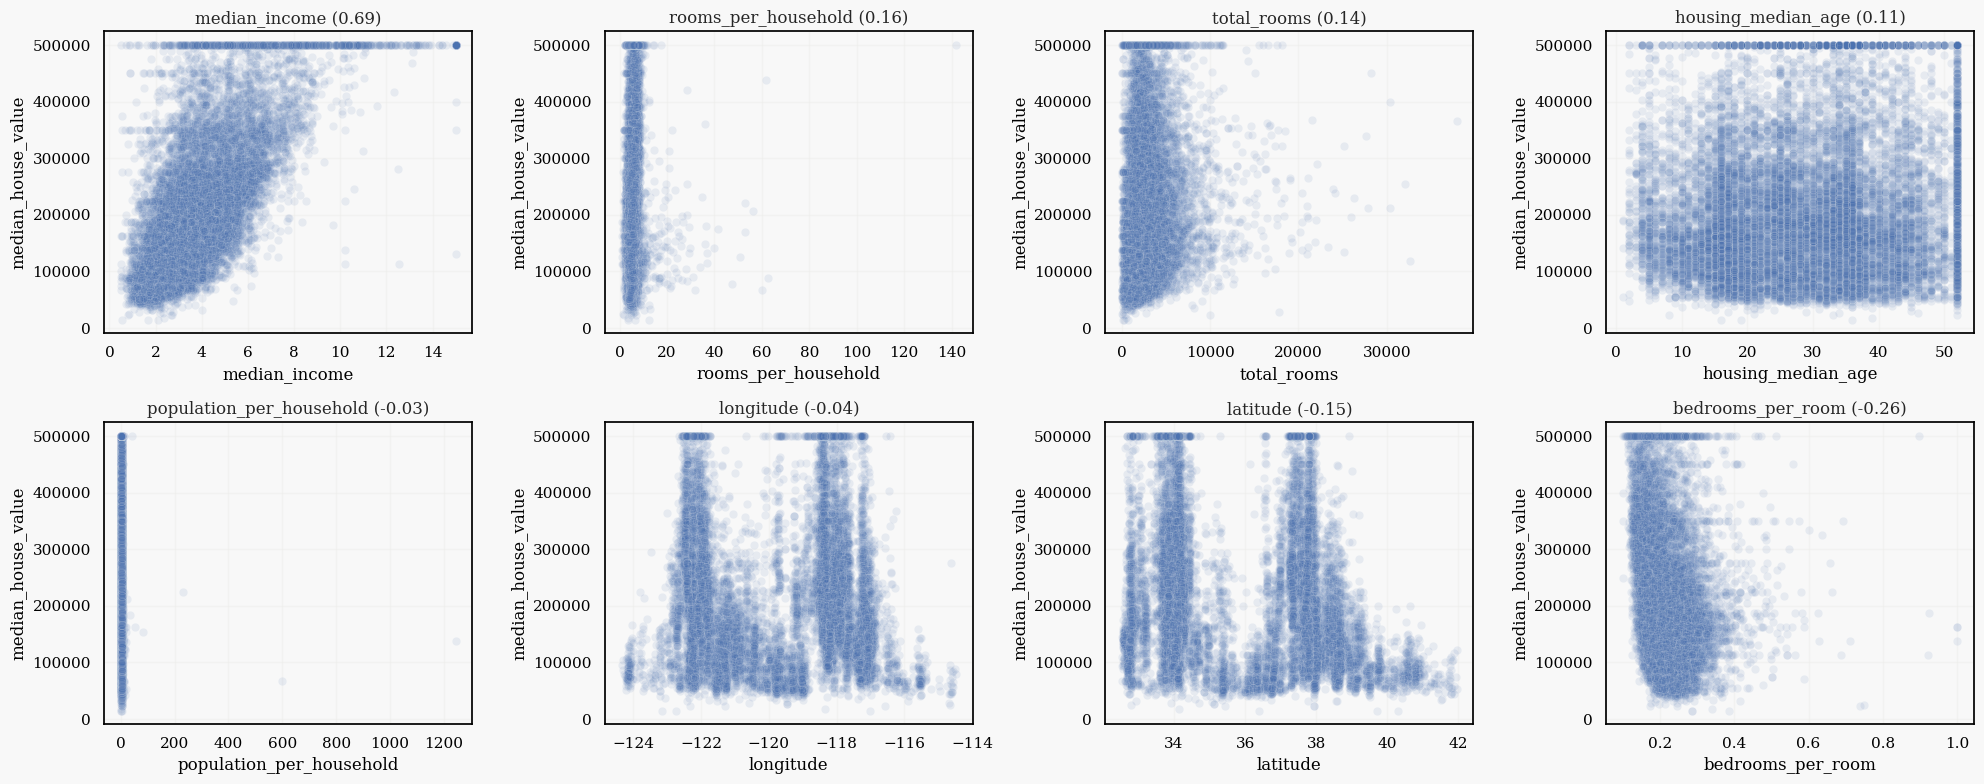

In [37]:
target_corr = housing.corr(numeric_only=True)['median_house_value'].drop('median_house_value', axis=0).sort_values(ascending=False)
target_corr = round(target_corr,2)

fig, axs = plt.subplots(2,4, figsize=(20,8))
axs = axs.ravel()

for i, (key, corr) in enumerate(target_corr.items()):
  axs[i].set_title(f'{key} ({corr})')
  sns.scatterplot(housing, x=key, y="median_house_value", alpha=0.1, ax=axs[i])
plt.tight_layout()

# Pipeline

Passos
Crie uma pipeline para fazer as seguintes transformações de acordo a cada codigo:

1° 
```
housing['ocean_proximity'] = housing['ocean_proximity'].apply(lambda x: 'NEAR OCEAN' if x == 'ISLAND' else x)
```

2°
```
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']
```

3°

```
median = housing['total_bedrooms']
housing['total_bedrooms'].fillna(median, inplace=True)
```

4° Selecione as colunas

```
columns = [
    'longitude',
    'latitude',
    'housing_median_age',
    'total_rooms',
    'median_income',
    'median_house_value',
    'ocean_proximity',
    'rooms_per_household',
    'bedrooms_per_room',
    'population_per_household'
    ]
housing = housing[columns]
```

5° Standard Scaler nas categorias númericas

6° One hot na coluna `ocean_proximity``

Utlize na pipeline três passos apenas, simple imputer, FeatureUnion, standard scaler, separe a pipeline final com a pipilene das transofrmações das variaveis continuas e a outra com as categoricas

In [40]:
def function_features_transformer(data):
    data['ocean_proximity'] = data['ocean_proximity'].apply(lambda x: 'NEAR OCEAN' if x == 'ISLAND' else x)
    data['rooms_per_household'] = data['total_rooms'] / data['households']
    data['bedrooms_per_room'] = data['total_bedrooms'] / data['total_rooms']
    data['population_per_household'] = data['population'] / data['households']
    final_columns = [ 'longitude', 'latitude', 'housing_median_age', 'total_rooms', 'median_income', 'ocean_proximity', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household' ]
    return data[final_columns]
    
features_transformer = FunctionTransformer(function_features_transformer)

categorical_features = ['ocean_proximity']
numeric_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'median_income', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline final
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

pipeline = Pipeline(steps=[
    ('features', features_transformer),
    ('preprocessor', preprocessor)
])

pipeline

Pipeline(steps=[('features',
                 FunctionTransformer(func=<function function_features_transformer at 0x7fda0814eef0>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'median_income',
                                                   'rooms_per_household',
                                                   'bedrooms_per_room',
                                                   'population_per_household']),
                                                 ('cat', OneHotEncoder(),
                                                  ['ocean_proximity'])]))])

# First Model

In [41]:
X = train.drop('median_house_value', axis=1)
y = train['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [42]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

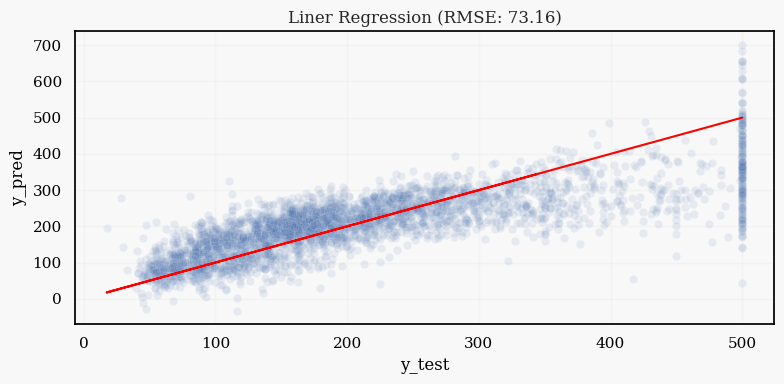

In [43]:
result = pd.concat([y_test.reset_index(drop=True), pd.Series(y_pred)], axis=1)
result.columns = [ 'y_test', 'y_pred' ]

rmse = round(np.sqrt(mean_squared_error(result.y_test, result.y_pred)), 2)

plt.figure(figsize=(8,4))
ax = sns.scatterplot(result, 
                     x='y_test', 
                     y='y_pred', alpha=0.1)

plt.plot(result.y_test, result.y_test, color='red')

ax.set_title(f'Liner Regression (RMSE: {rmse})')
plt.tight_layout()

# Testing a lot of Algorithms

In [44]:
algorithms = {
    'LR': LinearRegression(),
    'KNN' : KNeighborsRegressor(),
    'DT': DecisionTreeRegressor(),
    'RF': RandomForestRegressor(),
    'XGB': XGBRegressor(),
    'LGBM': LGBMRegressor(),
    'CAT': CatBoostRegressor(loss_function='RMSE', logging_level='Silent')
}

In [47]:
def test_algorithms(X,y):
  result = pd.DataFrame()

  for key, algorithm in algorithms.items():
    start_time = time.time()
    print(f'{key}...', end = '')
    model = Pipeline(steps=[
    ('features', features_transformer),
    ('preprocessor', preprocessor),
    (key, algorithm)
    ])
    rmse_scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5))
    new_row = {
        'Algorithm': key,
        'Mean': round(rmse_scores.mean(), 2),
        'Std': round(rmse_scores.std(), 2),
        'Run_Time': round((time.time() - start_time) / 60, 2),
        'Scores': rmse_scores
      }

    result = pd.concat([result, pd.Series(new_row)], axis=1)
    print(f'finished!!! {round((time.time() - start_time) / 60, 2)} min(s).')
  return result.transpose().sort_values(by='Mean', ascending=False).reset_index(drop=True)

In [48]:
results = test_algorithms(X,y)

LR...finished!!! 0.01 min(s).
KNN...finished!!! 0.07 min(s).
DT...finished!!! 0.03 min(s).
RF...finished!!! 1.02 min(s).
XGB...finished!!! 0.23 min(s).
LGBM...finished!!! 0.03 min(s).
CAT...finished!!! 0.48 min(s).


In [49]:
results

Algorithm      Mean      Std Run_Time  \
0        LR  70791.71    971.8     0.01   
1        DT  70693.06  1517.07     0.03   
2       KNN  64026.99   680.37     0.07   
3        RF   50308.1   504.25     1.02   
4       XGB  47524.83   918.79     0.23   
5      LGBM  46517.97   630.87     0.03   
6       CAT  44528.25   692.41     0.48   

                                              Scores  
0  [69689.42013678413, 70424.54117062048, 71142.6...  
1  [72892.07491357255, 68801.3052785908, 70171.36...  
2  [64443.48207797899, 64056.7349317615, 65038.47...  
3  [49755.4968220445, 50493.45974054612, 50268.81...  
4  [46762.59888943291, 48485.92975587079, 46251.0...  
5  [46405.92057382673, 46711.29516984631, 45416.6...  
6  [43879.0520441782, 45439.07527042868, 43797.37...

<Axes: xlabel='Algorithm', ylabel='Mean'>

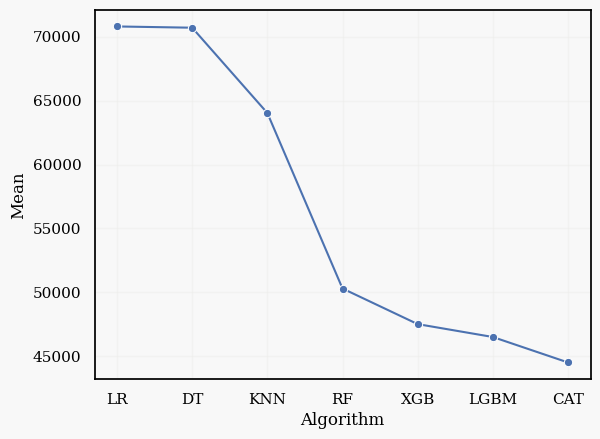

In [50]:
sns.lineplot(results, x='Algorithm', y='Mean', marker='o')

In [51]:
results

Algorithm      Mean      Std Run_Time  \
0        LR  70791.71    971.8     0.01   
1        DT  70693.06  1517.07     0.03   
2       KNN  64026.99   680.37     0.07   
3        RF   50308.1   504.25     1.02   
4       XGB  47524.83   918.79     0.23   
5      LGBM  46517.97   630.87     0.03   
6       CAT  44528.25   692.41     0.48   

                                              Scores  
0  [69689.42013678413, 70424.54117062048, 71142.6...  
1  [72892.07491357255, 68801.3052785908, 70171.36...  
2  [64443.48207797899, 64056.7349317615, 65038.47...  
3  [49755.4968220445, 50493.45974054612, 50268.81...  
4  [46762.59888943291, 48485.92975587079, 46251.0...  
5  [46405.92057382673, 46711.29516984631, 45416.6...  
6  [43879.0520441782, 45439.07527042868, 43797.37...

# Hyperparameter Tuning

In [54]:
# Define the hyperparameters for random search
param_dist = {
    'iterations': [100, 200, 300],           # Number of iterations
    'learning_rate': [0.01, 0.05, 0.1],       # Learning rate
    'depth': [3, 5, 7],                       # Tree depth
    'l2_leaf_reg': [1, 3, 5]                  # L2 regularization
}

# Create the CatBoost Regressor model
model = CatBoostRegressor()

# Perform random search for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    cv=5,
    scoring='neg_mean_squared_error',
    n_iter=10
)

In [55]:
# Fit the model to the training data
random_search.fit(X_train, y_train)

# Print the best hyperparameters found
print('Best Hyperparameters:')
print(random_search.best_params_)

# Evaluate the model performance with the best hyperparameters
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_train)

A saída de streaming foi truncada nas últimas 5000 linhas.
3:	learn: 91780.6649867	total: 41.5ms	remaining: 3.07s
4:	learn: 87430.1113673	total: 48ms	remaining: 2.83s
5:	learn: 83656.5294794	total: 53.8ms	remaining: 2.64s
6:	learn: 80517.1706682	total: 59.8ms	remaining: 2.5s
7:	learn: 77500.7157122	total: 68.6ms	remaining: 2.5s
8:	learn: 75056.8418461	total: 84.1ms	remaining: 2.72s
9:	learn: 72766.6166641	total: 98.1ms	remaining: 2.84s
10:	learn: 70780.4897350	total: 109ms	remaining: 2.85s
11:	learn: 69066.3640108	total: 115ms	remaining: 2.77s
12:	learn: 67444.0499798	total: 121ms	remaining: 2.68s
13:	learn: 65945.0956885	total: 128ms	remaining: 2.62s
14:	learn: 64655.4713514	total: 135ms	remaining: 2.56s
15:	learn: 63725.0291152	total: 151ms	remaining: 2.68s
16:	learn: 62821.6991501	total: 166ms	remaining: 2.77s
17:	learn: 61965.8308605	total: 174ms	remaining: 2.72s
18:	learn: 61273.5127346	total: 183ms	remaining: 2.71s
19:	learn: 60577.1724050	total: 195ms	remaining: 2.73s
20:	learn:

In [56]:
mse = mean_squared_error(y_train, y_pred)
print('RMSE: {:.2f}'.format(np.sqrt(mse)))

RMSE: 35288.86
